In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, RepeatedKFold, RepeatedStratifiedKFold, StratifiedKFold

import sklearn.metrics as metrics

# Herramientas
import tools as t

import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("data/hospital_train.csv")

##### PASO 1
column_names = pd.read_csv("data/columns_meaning.csv", index_col = 0)
column_names_dict = column_names.to_dict()
df.columns = column_names_dict["Description"].values()

##### PASO 2
# Paso las variables nominales a dummies
df = pd.get_dummies(df, prefix = ["hospital_type", "hospital_city", "hospital_region", "department", "ward_type", "ward_facility"], columns = ["Unique code for the type of Hospital", "City Code of the Hospital", "Region Code of the Hospital", "Department overlooking the case", "Code for the Ward type", "Code for the Ward Facility"])


##### PASO 3
# Admission Type registered by the Hospital
dict_1 = {
    "Emergency" : 1,
    "Trauma" : 2,
    "Urgent" : 3
}

# Severity of the illness recorded at the time of admission
dict_2 = {
    "Minor" : 1,
    "Moderate" : 2,
    "Extreme" : 3
}

# Age of the patient
dict_3 = {
    "0-10" : 1,
    "11-20" : 2,
    "21-30" : 3,
    "31-40" : 4,
    "41-50" : 5,
    "51-60" : 6,
    "61-70" : 7,
    "71-80" : 8,
    "81-90" : 9,
    "91-100" : 10,
}

# Stay Days by the patient
dict_4 = {
    "0-10" : 1,
    "11-20" : 2,
    "21-30" : 3,
    "31-40" : 4,
    "41-50" : 5,
    "51-60" : 6,
    "61-70" : 7,
    "71-80" : 8,
    "81-90" : 9,
    "91-100" : 10,
    "More than 100 Days" : 11
}

dicts = [dict_1, dict_2, dict_3, dict_4]

columns = ["Admission Type registered by the Hospital", "Severity of the illness recorded at the time of admission", "Age of the patient", "Stay Days by the patient"]

df = t.column_mapper(df, columns, dicts)

##### PASO 4
##### Elimino las variables que no necesito
#df.drop(["Admission Type registered by the Hospital", "Severity of the illness recorded at the time of admission", "Age of the patient", "Stay Days by the patient"], axis = 1, inplace = True)

##### PASO 5
# Condition of Bed in the Ward 
df.iloc[:, 3] = df.iloc[:, 3].fillna(df.iloc[:, 3].mode()[0])
# City Code for the patient
df.iloc[:, 5] = df.iloc[:, 5].fillna(df.iloc[:, 5].mode()[0])


df.head()

,Case_ID registered in Hospital,Unique code for the Hospital,Number of Extra rooms available in the Hospital,Condition of Bed in the Ward,Unique Patient Id,City Code for the patient,Admission Type registered by the Hospital,Severity of the illness recorded at the time of admission,Number of Visitors with the patient,Age of the patient,...,ward_type_R,ward_type_S,ward_type_T,ward_type_U,ward_facility_A,ward_facility_B,ward_facility_C,ward_facility_D,ward_facility_E,ward_facility_F
0,161528,6,2,4.0,45810,2.0,3,2,2,3,...,1,0,0,0,0,0,0,0,0,1
1,159472,23,4,2.0,128565,15.0,2,2,4,6,...,0,0,0,0,0,0,0,0,0,1
2,309765,2,2,3.0,46565,5.0,3,2,2,8,...,0,1,0,0,0,0,0,0,0,1
3,279614,32,3,4.0,124546,6.0,1,2,4,2,...,0,1,0,0,0,1,0,0,0,0
4,147791,14,3,2.0,22729,8.0,3,2,2,6,...,0,1,0,0,0,0,0,0,1,0


In [7]:
# Independent variables
X = np.array(df.drop("Stay Days by the patient", axis = 1))

# Dependent variable
y = np.array(df["Stay Days by the patient"])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

# Cross validation
#kfold = RepeatedKFold(n_splits = 10, n_repeats = 1, random_state = 42)
kfold = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1, random_state = 42)

# Model
#model = RandomForestClassifier(n_jobs = -1, random_state = 42)
#model = LinearSVC(random_state = 42, max_iter = 1000)
#model = KNeighborsClassifier(n_neighbors = 5, n_jobs = -1)
model = GradientBoostingClassifier(random_state = 42)

In [8]:
train_scores = []
val_scores = []
count = 1

for (train, val) in kfold.split(X_train, y_train):

    #print(train)
    #print(val)

    # Train-Validation sets
    x_t, y_t = X_train[train], y_train[train]
    x_v, y_v = X_train[val], y_train[val]


    # Internal structure
    y_t_unique, y_t_counts = np.unique(y_t, return_counts=True)
    y_v_unique, y_v_counts = np.unique(y_v, return_counts=True)

    # Training
    model.fit(x_t, y_t)

    # Scores
    train_score = model.score(x_t, y_t)
    val_score = model.score(x_v, y_v)

    train_scores.append(train_score)
    val_scores.append(val_score)

    print(f"Model {count}")
    print("-" * 25)
    print("Set structure:")
    print("Train structure:", dict(zip(y_t_unique, y_t_counts / len(y_t))))
    print("Validation structure:", dict(zip(y_v_unique, y_v_counts / len(y_v))))
    print("-" * 25)
    print("train score:", train_score)
    print("test score:", val_score)
    print("#" * 75)

    count += 1

Model 1
-------------------------
Set structure:
Train structure: {1: 0.07445833333333333, 2: 0.2439861111111111, 3: 0.27395833333333336, 4: 0.172875, 5: 0.03723611111111111, 6: 0.10990277777777778, 7: 0.00875, 8: 0.03305555555555555, 9: 0.014708333333333334, 10: 0.009041666666666667, 11: 0.022027777777777778}
Validation structure: {1: 0.074375, 2: 0.244, 3: 0.274, 4: 0.172875, 5: 0.037125, 6: 0.109875, 7: 0.00875, 8: 0.033125, 9: 0.014625, 10: 0.009125, 11: 0.022125}
-------------------------
train score: 0.42769444444444443
test score: 0.407875
###########################################################################
Model 2
-------------------------
Set structure:
Train structure: {1: 0.07445833333333333, 2: 0.2439861111111111, 3: 0.27395833333333336, 4: 0.172875, 5: 0.03723611111111111, 6: 0.10990277777777778, 7: 0.00875, 8: 0.03305555555555555, 9: 0.014708333333333334, 10: 0.009041666666666667, 11: 0.022027777777777778}
Validation structure: {1: 0.074375, 2: 0.244, 3: 0.274, 4: 

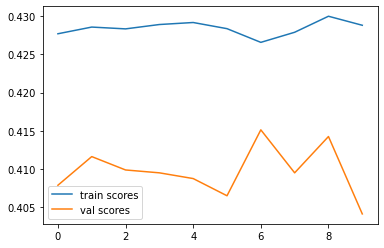

In [9]:
plt.plot(train_scores)
plt.plot(val_scores)
plt.legend(["train scores", "val scores"])

In [10]:
# Training with full train_data
model.fit(X_train, y_train)

# Internal structure
y_train_unique, y_train_counts = np.unique(y_train, return_counts=True)
y_test_unique, y_test_counts = np.unique(y_test, return_counts=True)

# Scores
train_score_ = model.score(X_train, y_train)
test_score_ = model.score(X_test, y_test)

# Prediction
prediction = model.predict(X_test)

# Confusion matrix
cm = metrics.confusion_matrix(y_test, prediction)

print("Train set model:")
print("#" * 50)
print("\nTrain structure:", dict(zip(y_train_unique, y_train_counts / len(y_train) * 100)))
print("Train score:", train_score_)
print("#" * 50)
print("\nTest set model:")
print("Validation structure:", dict(zip(y_test_unique, y_test_counts / len(y_test) * 100)))
print("Test score:", test_score_)
print("#" * 50)
print("\nConfusion matrix\n", cm)

Train set model:
##################################################

Train structure: {1: 7.445, 2: 24.39875, 3: 27.39625, 4: 17.2875, 5: 3.7225, 6: 10.99, 7: 0.8750000000000001, 8: 3.3062500000000004, 9: 1.47, 10: 0.905, 11: 2.2037500000000003}
Train score: 0.427125
##################################################

Test set model:
Validation structure: {1: 7.355, 2: 24.785, 3: 27.675, 4: 17.405, 5: 3.45, 6: 10.96, 7: 0.7849999999999999, 8: 3.26, 9: 1.47, 10: 0.9199999999999999, 11: 1.9349999999999998}
Test score: 0.41425
##################################################

Confusion matrix
 [[ 202  702  557    4    0    4    0    0    0    2    0]
 [  89 2500 1987  156    0  219    3    0    2    0    1]
 [  77 1647 3643   50    5   93    3    0    8    2    7]
 [  47  613 1488  493    1  812    4    3    4    1   15]
 [  27  155  411   28    2   62    0    0    1    2    2]
 [  18  190  342  347    2 1213    1    1   44    1   33]
 [   2   22   88    7    0   29    0    1    3    0 

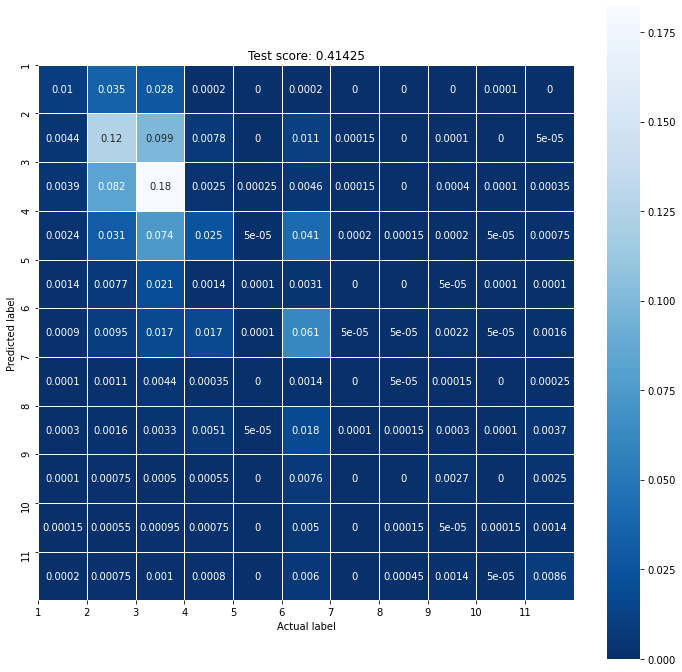

In [12]:
plt.figure(figsize = (12, 12))

sns.heatmap(cm / len(y_test), annot = True, linewidths = .5, square = True, cmap = "Blues_r")

plt.xticks(range(0, 11), range(1, 12))
plt.yticks(range(0, 11), range(1, 12))

plt.xlabel("Actual label")
plt.ylabel("Predicted label")

plt.title(f"Test score: {test_score_}")

plt.show()

# Submission

In [16]:
column_names = pd.read_csv("data/columns_meaning.csv", index_col = 0)
column_names

,Description
Column,
0,Case_ID registered in Hospital
1,Unique code for the Hospital
2,Unique code for the type of Hospital
3,City Code of the Hospital
4,Region Code of the Hospital
5,Number of Extra rooms available in the Hospital
6,Department overlooking the case
7,Code for the Ward type
8,Code for the Ward Facility


In [20]:
X_pred = pd.read_csv("data/hospital_test.csv")

##### PASO 1
column_names = pd.read_csv("data/columns_meaning.csv", index_col = 0)[:-1]
column_names_dict = column_names.to_dict()
X_pred.columns = column_names_dict["Description"].values()

##### PASO 2
# Paso las variables nominales a dummies
X_pred = pd.get_dummies(X_pred, prefix = ["hospital_type", "hospital_city", "hospital_region", "department", "ward_type", "ward_facility"], columns = ["Unique code for the type of Hospital", "City Code of the Hospital", "Region Code of the Hospital", "Department overlooking the case", "Code for the Ward type", "Code for the Ward Facility"])


##### PASO 3
# Admission Type registered by the Hospital
dict_1 = {
    "Emergency" : 1,
    "Trauma" : 2,
    "Urgent" : 3
}

# Severity of the illness recorded at the time of admission
dict_2 = {
    "Minor" : 1,
    "Moderate" : 2,
    "Extreme" : 3
}

# Age of the patient
dict_3 = {
    "0-10" : 1,
    "11-20" : 2,
    "21-30" : 3,
    "31-40" : 4,
    "41-50" : 5,
    "51-60" : 6,
    "61-70" : 7,
    "71-80" : 8,
    "81-90" : 9,
    "91-100" : 10,
}

dicts = [dict_1, dict_2, dict_3]

columns = ["Admission Type registered by the Hospital", "Severity of the illness recorded at the time of admission", "Age of the patient"]

X_pred = t.column_mapper(X_pred, columns, dicts)

##### PASO 5
# Condition of Bed in the Ward 
X_pred.iloc[:, 3] = X_pred.iloc[:, 3].fillna(df.iloc[:, 3].mode()[0])
# City Code for the patient
X_pred.iloc[:, 5] = X_pred.iloc[:, 5].fillna(df.iloc[:, 5].mode()[0])

X_pred.head()

,Case_ID registered in Hospital,Unique code for the Hospital,Number of Extra rooms available in the Hospital,Condition of Bed in the Ward,Unique Patient Id,City Code for the patient,Admission Type registered by the Hospital,Severity of the illness recorded at the time of admission,Number of Visitors with the patient,Age of the patient,...,ward_type_R,ward_type_S,ward_type_T,ward_type_U,ward_facility_A,ward_facility_B,ward_facility_C,ward_facility_D,ward_facility_E,ward_facility_F
0,314114,19,4,2.0,59278,8.0,1,1,2,5,...,0,1,0,0,0,0,1,0,0,0
1,208989,15,3,2.0,102253,15.0,2,2,3,4,...,0,1,0,0,0,0,0,0,0,1
2,305872,17,4,4.0,5828,4.0,1,1,3,8,...,1,0,0,0,0,0,0,0,1,0
3,266099,3,4,2.0,56642,9.0,3,3,4,4,...,1,0,0,0,1,0,0,0,0,0
4,13228,6,4,1.0,116266,8.0,1,1,3,3,...,1,0,0,0,0,0,0,0,0,1


In [23]:
dict_5 = {
    1 : "0-10",
    2 : "11-20",
    3 : "21-30",
    4 : "31-40",
    5 : "41-50",
    6 : "51-60",
    7 : "61-70",
    8 : "71-80",
    9 : "81-90",
    10 : "91-100",
    11 : "More than 100 Days"
}

to_submit = X_pred
to_submit["prediction"] = model.predict(X_pred)

to_submit = to_submit[["Case_ID registered in Hospital", "prediction"]]
to_submit.columns = ["id", "days"]
to_submit.days = to_submit.days.map(dict_5)
to_submit.set_index("id", inplace = True)

to_submit.head()

,days
id,
314114,11-20
208989,51-60
305872,11-20
266099,51-60
13228,21-30


In [25]:
to_submit.to_csv("submissions/submission1.csv")